<img src="https://avatars.githubusercontent.com/u/63704085?s=400&u=5dc6c45b7d457ce6f303fbc612091cb2c133482f&v=4" alt="sar2cube logo" style="float: top; max-width: 200px" />

## Use Case 2: Land Cover Classification Mapping

In [11]:
# Import necessary libraries
# System
import os
import sys
from time import time
# Math
import math
import numpy as np
from scipy.interpolate import griddata
# Geography
from osgeo import gdal, osr
from pyproj import Proj, transform, Transformer, CRS
import rasterio
# Datacubes and databases
import datacube
import xarray as xr
import rioxarray
import pandas as pd
# Parallel Computing
import dask
from dask.distributed import Client
# Graphic
from matplotlib import pyplot as plt
# SAR2Cube specific
from sar2cube_utils import create_S2grid
from landcover_classification import *
from geo_utils import *
import warnings
warnings.filterwarnings('ignore')

### Attach to the Dask Cluster

In [12]:
client = Client('tcp://10.8.244.123:8786')
dask.config.set(**{'array.slicing.split_large_chunks': False})
client

Client Scheduler: tcp://10.8.244.123:8786 Dashboard: http://10.8.244.123:40053/status,Cluster Workers: 2 Cores: 32 Memory: 142.00 GB


## Level-0 Datacube loading

In [13]:
dc = datacube.Datacube(config = '/home/mclaus@eurac.edu/.datacube.conf')
sent1 = dc.load(product = 'SAR2Cube_L0_117_ASC_ST_2016_2020', time=["2018-01-01","2018-12-31"], dask_chunks={'time':1,'x':2000,'y':2000})
sent1

,Array,Chunk
Bytes,75.46 GB,16.00 MB
Shape,"(55, 7751, 44250)","(1, 2000, 2000)"
Count,5115 Tasks,5060 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,75.46 GB,16.00 MB
Shape,"(55, 7751, 44250)","(1, 2000, 2000)"
Count,5115 Tasks,5060 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## Spatial Subsetting for Meran area

In [14]:
start = time()
meran_bbox = [10.948562622070312,46.54091587805394,11.337203979492188,46.78407569031799]
bbox_mask = np.bitwise_and(np.bitwise_and(sent1.grid_lon[0]>meran_bbox[0],sent1.grid_lon[0]<meran_bbox[2]),np.bitwise_and(sent1.grid_lat[0]>meran_bbox[1],sent1.grid_lat[0]<meran_bbox[3]))
sent1_subset = sent1.where(bbox_mask,drop=True)
print('Elapsed time: ', time()-start)
sent1_subset

Elapsed time:  9.897553205490112


,Array,Chunk
Bytes,4.60 GB,9.36 MB
Shape,"(55, 2284, 9145)","(1, 1170, 2000)"
Count,18739 Tasks,660 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,4.60 GB,9.36 MB
Shape,"(55, 2284, 9145)","(1, 1170, 2000)"
Count,18739 Tasks,660 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## Coherence computation with 6 days difference

### We firstly need to find the 6 days pairs

In [15]:
# We put the timesteps of the datacube into an array
timesteps = sent1_subset.time.values
six_days_pairs = []
# We loop through the timesteps and check where we have 6 days pairs of dates
for i,t in enumerate(timesteps[:-1]):
    if(np.timedelta64(timesteps[i+1] - timesteps[i], 'D')) == np.timedelta64(6,'D'):
        six_days_pairs.append([timesteps[i],timesteps[i+1]])

In [16]:
six_days_pairs = np.asarray(six_days_pairs)
print('Sample date pair with 6 days difference:',six_days_pairs[0])

Sample date pair with 6 days difference: ['2018-01-01T23:59:59.000000000' '2018-01-07T23:59:59.000000000']


### We need to compute the parameters needed for geocoding

Apply MultiLook to coordinates grid for geocoding

In [17]:
sent1_ML = sent1_subset.drop('i_VH').drop('i_VV').drop('q_VH').drop('q_VV')
sent1_ML = sent1_ML.coarsen(y=4,boundary='trim').mean().coarsen(x=19,boundary='trim').mean()

Define the output projection and resolution.

In [18]:
spatialres = 20
output_crs = "epsg:32632"

Create a grid aligned with the Sentinel-2 one.

In [19]:
x_regular, y_regular, grid_x_irregular, grid_y_irregular = create_S2grid(sent1_ML,output_crs,spatialres)
grid_x_regular, grid_y_regular = np.meshgrid(x_regular,y_regular)
grid_x_regular

Irregular grid bounds:  648741.04805355 5156000.545562474 679188.0966784435 5183816.313552391
Aligned with S2 grid bounds:  648740.0 5156000.0 679200.0 5183820.0


array([[648750., 648770., 648790., ..., 679170., 679190., 679210.],
       [648750., 648770., 648790., ..., 679170., 679190., 679210.],
       [648750., 648770., 648790., ..., 679170., 679190., 679210.],
       ...,
       [648750., 648770., 648790., ..., 679170., 679190., 679210.],
       [648750., 648770., 648790., ..., 679170., 679190., 679210.],
       [648750., 648770., 648790., ..., 679170., 679190., 679210.]],
      dtype=float32)

### Create output dataset

In [20]:
# Compute the transformation only once
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator

geocoded_cube = xr.Dataset(
    {
        "VV_coh": (["time","y", "x"], np.zeros((len(six_days_pairs),len(y_regular),len(x_regular)))),
        "VH_coh": (["time","y", "x"], np.zeros((len(six_days_pairs),len(y_regular),len(x_regular))))
    }, 
    coords={
        "time": (["time"],six_days_pairs[:,0]),
        "y": (["y"],y_regular),
        "x": (["x"],x_regular)
    },
)

grid_irregular_flat = np.asarray([grid_x_irregular.flatten(), grid_y_irregular.flatten()]).T
grid_regular_flat = np.asarray([grid_x_regular.flatten(), grid_y_regular.flatten()]).T
shape = grid_x_regular.shape

### Compute point-coordinates triangulation for geocoding.

In [21]:
%time delaunay_obj = Delaunay(grid_irregular_flat)  # Compute the triangulation

CPU times: user 2.61 s, sys: 77.9 ms, total: 2.69 s
Wall time: 2.68 s


### Compute geocoded Coherence for the full time-series

In [12]:
%%time
for i,pair in enumerate(six_days_pairs):
    print(pair)
    # Compute real and imaginary part of the Coherence
    VV_q_coh = (sent1_subset.i_VV.loc[dict(time=pair[0])]*sent1_subset.i_VV.loc[dict(time=pair[1])]+sent1.q_VV.loc[dict(time=pair[0])]*sent1_subset.q_VV.loc[dict(time=pair[1])])/np.sqrt((sent1_subset.i_VV.loc[dict(time=pair[0])]**2+sent1_subset.q_VV.loc[dict(time=pair[0])]**2)*(sent1_subset.i_VV.loc[dict(time=pair[1])]**2+sent1_subset.q_VV.loc[dict(time=pair[1])]**2))
    VV_i_coh = (sent1_subset.i_VV.loc[dict(time=pair[1])]*sent1_subset.q_VV.loc[dict(time=pair[0])]-sent1.i_VV.loc[dict(time=pair[0])]*sent1_subset.q_VV.loc[dict(time=pair[1])])/np.sqrt((sent1_subset.i_VV.loc[dict(time=pair[0])]**2+sent1_subset.q_VV.loc[dict(time=pair[0])]**2)*(sent1_subset.i_VV.loc[dict(time=pair[1])]**2+sent1_subset.q_VV.loc[dict(time=pair[1])]**2))
    VH_q_coh = (sent1_subset.i_VH.loc[dict(time=pair[0])]*sent1_subset.i_VH.loc[dict(time=pair[1])]+sent1.q_VH.loc[dict(time=pair[0])]*sent1_subset.q_VH.loc[dict(time=pair[1])])/np.sqrt((sent1_subset.i_VH.loc[dict(time=pair[0])]**2+sent1_subset.q_VH.loc[dict(time=pair[0])]**2)*(sent1_subset.i_VH.loc[dict(time=pair[1])]**2+sent1_subset.q_VH.loc[dict(time=pair[1])]**2))
    VH_i_coh = (sent1_subset.i_VH.loc[dict(time=pair[1])]*sent1_subset.q_VH.loc[dict(time=pair[0])]-sent1.i_VH.loc[dict(time=pair[0])]*sent1_subset.q_VH.loc[dict(time=pair[1])])/np.sqrt((sent1_subset.i_VH.loc[dict(time=pair[0])]**2+sent1_subset.q_VH.loc[dict(time=pair[0])]**2)*(sent1_subset.i_VH.loc[dict(time=pair[1])]**2+sent1_subset.q_VH.loc[dict(time=pair[1])]**2))
    # Compute the Multi-Look over the real and imaginary parts
    VV_q_coh_ML = VV_q_coh.coarsen(y=4,boundary='trim').mean().coarsen(x=19,boundary='trim').mean()
    VV_i_coh_ML = VV_i_coh.coarsen(y=4,boundary='trim').mean().coarsen(x=19,boundary='trim').mean()

    VH_q_coh_ML = VH_q_coh.coarsen(y=4,boundary='trim').mean().coarsen(x=19,boundary='trim').mean()
    VH_i_coh_ML = VH_i_coh.coarsen(y=4,boundary='trim').mean().coarsen(x=19,boundary='trim').mean()
    # Compute the Magnitude for both polarizations
    VV_coh_mag = np.sqrt(VV_q_coh_ML**2+VV_i_coh_ML**2)
    VH_coh_mag = np.sqrt(VH_q_coh_ML**2+VH_i_coh_ML**2)
    
    interpolator  = LinearNDInterpolator(delaunay_obj, VV_coh_mag.values.flatten())
    geocoded_data = interpolator(grid_regular_flat)
    geocoded_data = geocoded_data.reshape(shape)
    geocoded_cube['VV_coh'][i] = geocoded_data
    interpolator  = LinearNDInterpolator(delaunay_obj, VH_coh_mag.values.flatten())
    geocoded_data = interpolator(grid_regular_flat)
    geocoded_data = geocoded_data.reshape(shape)
    geocoded_cube['VH_coh'][i] = geocoded_data


['2018-01-01T23:59:59.000000000' '2018-01-07T23:59:59.000000000']
['2018-01-07T23:59:59.000000000' '2018-01-13T23:59:59.000000000']
['2018-01-13T23:59:59.000000000' '2018-01-19T23:59:59.000000000']
['2018-01-19T23:59:59.000000000' '2018-01-25T23:59:59.000000000']
['2018-01-25T23:59:59.000000000' '2018-01-31T23:59:59.000000000']
['2018-01-31T23:59:59.000000000' '2018-02-06T23:59:59.000000000']
['2018-02-06T23:59:59.000000000' '2018-02-12T23:59:59.000000000']
['2018-02-12T23:59:59.000000000' '2018-02-18T23:59:59.000000000']
['2018-03-14T23:59:59.000000000' '2018-03-20T23:59:59.000000000']
['2018-03-20T23:59:59.000000000' '2018-03-26T23:59:59.000000000']
['2018-04-19T23:59:59.000000000' '2018-04-25T23:59:59.000000000']
['2018-04-25T23:59:59.000000000' '2018-05-01T23:59:59.000000000']
['2018-05-01T23:59:59.000000000' '2018-05-07T23:59:59.000000000']
['2018-05-07T23:59:59.000000000' '2018-05-13T23:59:59.000000000']
['2018-05-13T23:59:59.000000000' '2018-05-19T23:59:59.000000000']
['2018-05-

OLD SETTINGS (50GB RAM):

CPU times: user 1min 12s, sys: 3.67 s, total: 1min 16s
Wall time: 32min 18s

In [19]:
geocoded_cube_Meran = geocoded_cube.loc[dict(x=slice(652010,671990),y=slice(5161010,5180990))]

In [20]:
geocoded_cube_Meran.to_netcdf('./auxdata/UC2/coherence_timeseries_Meran_2018.nc')

# Random Forest Classification

### Define parameters and paths

In [22]:
# Define the number of sampling points & classification level (1 OR 3)
nr_points = 10000
class_level = 'LEVEL_3'
sampling_strategy = 'equal'

# Path to training data
training_path = './auxdata/UC2/ST_LVL3_SAR2Cube.tif'
vector_path = ''
# Mask for steep terrain
mask_path = './auxdata/UC2/radar_mask.tif'
# path of where to store the extracted training samples
sample_path = './auxdata/UC2/SAR2Cube_ST_training_10000_samples_equal.p'
stack_path ='./auxdata/UC2/coherence_timeseries_Meran_2018.nc'
# define the path to where to store your resulting classified map
class_path = './auxdata/UC2/SAR2Cube_classified.tif'

In [ ]:
training_samples, training_labels, bands_data, projection, geo_transform,training_pixels = prepare_training_data(training_path, stack_path, class_level, nr_points, sampling_strategy, sample_path=sample_path)

In [23]:
projection_32632 = 'PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32632"]]'

In [24]:
###############################
# Load saved training samples #
###############################

# this step is necessary if you want to use the same training pixels locations generated previously and stored
training_samples, training_labels, bands_data, projection, geo_transform, training_pixels = load_training_data(stack_path, training_path, sample_path)

Class 100 contains 714 pixels
Class 210 contains 551 pixels
Class 221 contains 714 pixels
Class 222 contains 714 pixels
Class 231 contains 714 pixels
Class 240 contains 71 pixels
Class 310 contains 714 pixels
Class 321 contains 714 pixels
Class 324 contains 714 pixels
Class 332 contains 714 pixels
Class 333 contains 714 pixels
Class 335 contains 714 pixels
Class 400 contains 704 pixels
Class 500 contains 714 pixels


In [25]:
################################
# Random forest classification #
################################

test_labels = [None]
test_samples = [None]
classified_image, classifier = classification(training_samples, training_labels, test_labels, test_samples, bands_data, projection_32632, geo_transform,'rf', gridsearch=False, n_estimators = 1000, mask_path=mask_path, class_path=class_path)


Starting Random Forest classification, lean back and wait for the magic to happen :) 


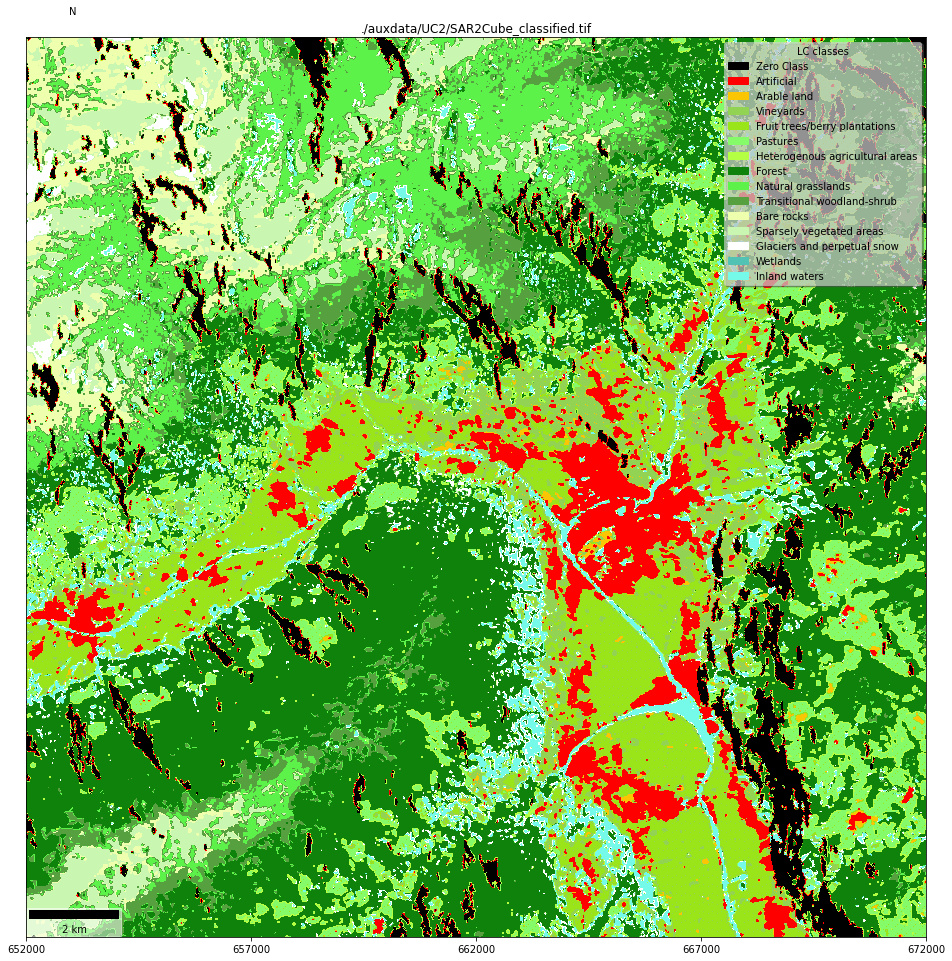

In [26]:
###############################
# Enjoy the looks of your MAP #
###############################

# plot your image to see the resulting classified map
%matplotlib inline
plot_classified_image(class_path=class_path, plot_map_info=True, plot_map_legend=True, plot_title=class_path)

### SinCohMap result:

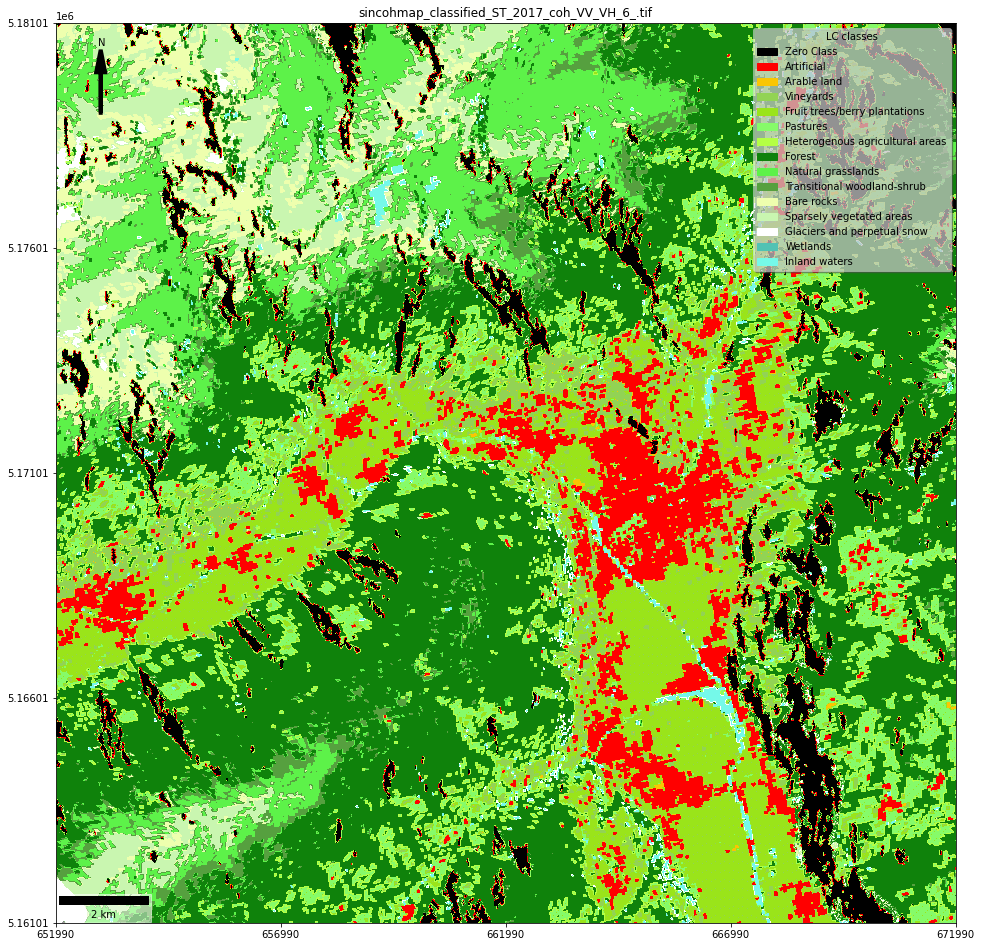

In [10]:

%matplotlib inline
plot_classified_image2(class_path='./auxdata/UC2/sincohmap_classified_ST_2017_coh_VV_VH_6_.tif', plot_map_info=True, plot_map_legend=True, plot_title='sincohmap_classified_ST_2017_coh_VV_VH_6_.tif')

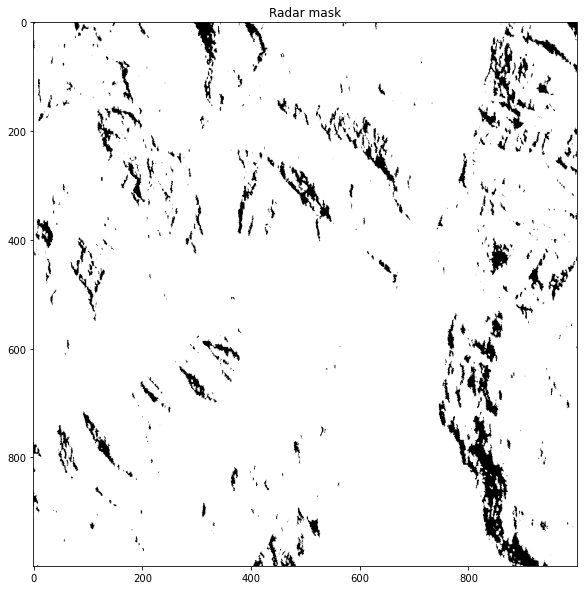

In [34]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_title('Radar mask')
ax.imshow(radar_mask[0].values,cmap='Greys_r', vmin=0, vmax=1)
plt.show()

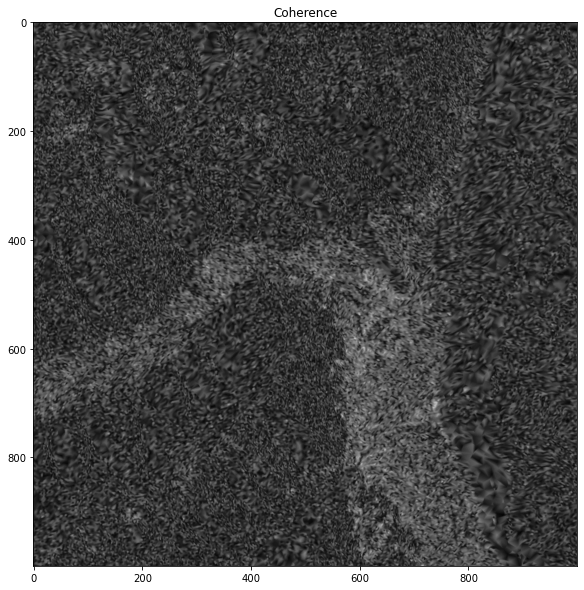

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_title('Coherence')
ax.imshow(np.flipud(geocoded_cube_Meran.VV_coh[0].values),cmap='Greys_r', vmin=0, vmax=1)
plt.show()